<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3b_OSI_SAF_sea_ice_mapping_Ice_Edge.ipynb" target="_blank"><< Mapping OSI SAF sea ice edge</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_3d_OSI_SAF_sea_ice_mapping_Ice_Drift.ipynb" target="_blank">Mapping OSI SAF sea ice drift >></a>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2024 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-sea-ice/HEAD?labpath=1_OSI_SAF_sea_ice_introductory%2F1_3c_OSI_SAF_sea_ice_mapping_ice_type.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF sea ice parameters : Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1_OSI_SAF_sea_ice_FTP_data_access.ipynb" target="_blank">1_1_OSI_SAF_sea_ice_FTP_data_access.ipynb</a>**

</div>
<hr>

# 1.3c Mapping OSI SAF sea ice type 
### Data used 

| Dataset | EUMETSAT collection ID | OSI SAF website description | OSI SAF identifier |
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| Global Sea Ice Type | EO:EUM:DAT:MULT:OSITYGBN | <a href="https://osi-saf.eumetsat.int/products/osi-403-d" target="_blank">Description</a> | OSI-403-d | 


### Learning outcomes

At the end of this notebook you will know;
* How to open Sea Ice Type netcdf
* Map Sea Ice Type using cartopy 


<div class="alert alert-info" role="alert">

## <a id='TOC-TOP'></a>Contents

</div>
    
 1. [Mapping sea ice type - Northern Hemisphere](#section1)
 1. [Mapping sea ice type - Southern Hemisphere](#section2)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
# library imports 
import os                               # a library that allows us access to basic operating system commands
import xarray as xr                     # a library that supports the use of multi-dimensional arrays in Python
import matplotlib as mpl                # a library for visualization
import matplotlib.patches as mpatches   # a part of the plotting library
import matplotlib.pyplot as plt         # a library that supports plotting
import matplotlib.cm as mpl_cm          # a part of the plotting library that provides colour maps
import cartopy.crs as ccrs              # a mapping library that supports reprojection
import cartopy.feature as cfeature      # a part of the mapping library that provides features such as coastlines
import cmocean                          # colormaps for ocean products
import cmcrameri                        # scientific colormaps for data visualisation
import numpy as np                      # a library that supports array manipulation
import warnings                         # a library that controls python warnings
warnings.filterwarnings('ignore')

##
<div class="alert alert-warning" role="alert">

## <a id='section0'></a>0. Supporting functions
[Back to top](#TOC-TOP)

</div>

Before we begin, we will define shorts functions.

The function name `mapping_ice_type` create a plot figure of sea ice concentration product available in the directory **directory** with a specific output projection and a specific region of the globe if given.

In [2]:
def mapping_ice_type(directory, output_projection, hemi, cmap, ax=None, title="", ice_shelves=None):
    """
    Function to map Sea Ice type. 

     Args:
        dir (string)        : the directory where files are
        output_projection   : the output projection to plot map
        hemi (string)       : hemisphere of the plot
        cmap                : color palette
        ax                  : axes of the plot
        ice_shelves         : ice shelves for southern hemisphere
        region (list)       : the region to zoom in. If not region is given, plot a global map
        title (string)      : title of the plot
    Returns:
        im                  : the plotting figure

    """

    # set data projection
    data_projection=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0)
    if hemi == 'sh': data_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0, true_scale_latitude=-70.0)

    # define plot carateristics
    if not ax : ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
    ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey', edgecolor='lightgrey')  # Change color of land
    ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
    #ax.coastlines()    # Add coastline
    if ice_shelves: ax.add_feature(ice_shelves, )
    
    # Add title
    plt.title(title, fontsize=20)

    # open and plot data
    for filename in os.listdir(directory):
        if filename.endswith(".nc"):
            nc = xr.open_dataset(os.path.join(directory, filename))
            xc = nc.variables['xc'][:] 
            yc = nc.variables['yc'][:]
            ice_type = nc.variables['ice_type'][:]
            status_flag  = nc.variables['status_flag'][:]
            nc.close()
            
            values = np.unique(ice_type.values.ravel())
            values = values[~np.isnan(values)]
            # Sea Ice Concentration data is provided in x y coordinates, bounds need to be defined for cartopy
            bounds=(xc.min()*1000,xc.max()*1000,yc.min()*1000,yc.max()*1000)
            
            # plotting sea ice
            im = ax.imshow(ice_type[0,:,:], transform=data_projection, extent=bounds, origin='upper', cmap=cmap)

    return im

The function name `add_legend` create a legend for the image im.

In [3]:
def add_legend(im):
    """
    Function to add legend for Sea Ice Type. 

     Args:
        im          : image
    """
    labels = ['no ice or very open ice', 'relatively young ice', 'ice that survived a summer melt', 'ambiguous ice type']
    colors = [ im.cmap(im.norm(value)) for value in [1,2,3,4]]
    # create a patch (proxy artist) for every color 
    patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(4) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(0.46, 0.12), loc=2, borderaxespad=0.1 , fontsize=10)

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Mapping sea ice type - Northern Hemisphere
[Back to top](#TOC-TOP)

</div>

Setting directory where to read data files

In [4]:
directory = os.path.join(os.getcwd(), 'products', 'SI_type', 'nh')

Let's check which data we are going to work with, and extract its date from the file name.

In [5]:
for filename in os.listdir(directory):
    filedate=filename[len(filename)-9:-7]+ '/' +filename[len(filename)-11:-9]+ '/' + filename[len(filename)-15:-11]

    print(filename)
    print('retrieval for:', filedate)


ice_type_nh_polstere-100_multi_202412251200.nc
retrieval for: 25/12/2024


We seen in the <a href="./1_2_OSI_SAF_sea_ice_file_structure.ipynb" target="_blank">file structure</a> notebook that our Sea Ice Type can be of one of the four value below:
* 1 -> no ice or very open ice
* 2 -> relatively young ice
* 3 -> ice that survived a summer melt
* 4 -> ambiguous ice type

Let's then map our data.

We can decide to choose a colormap for our data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
You may want to have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.hoosing color palet

In [6]:
#cmap = mpl_cm.get_cmap('YlGnBu_r')
#cmap = cmcrameri.cm.oslo
#cmap = cmocean.cm.ice
#cmap = cmcrameri.cm.nuuk

Or you can build up your own colorchart to represent the 4 categories.

In [7]:
from matplotlib.colors import ListedColormap

# Define your custom color palette
#custom_colors = ['#08306b', '#a5cce3', '#ffffff', '#fde725']
custom_colors = ['#08306b', '#4b98c9', '#ffffff', '#f59124']
# Create a ListedColormap
cmap = ListedColormap(custom_colors)
cmap.set_bad('grey')

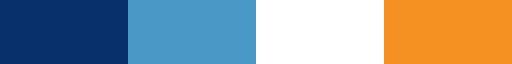

In [8]:
cmap

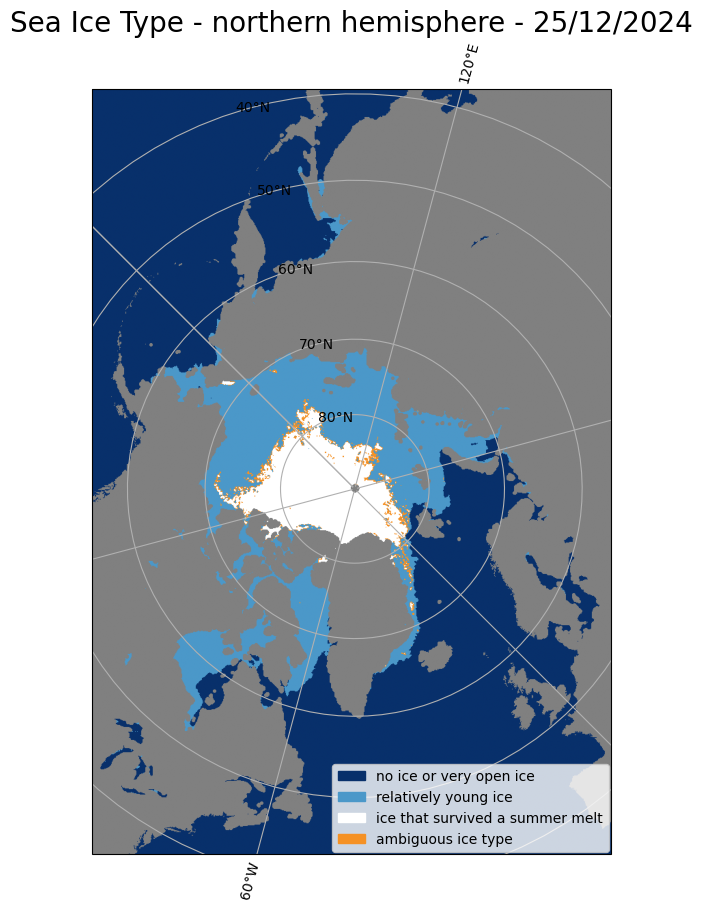

In [9]:
fig = plt.figure(figsize=(10,9))

# request output projection
hemi = 'nh'
output_projection=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0)

# Map sea ice edge
im = mapping_ice_type(directory, output_projection, hemi, cmap, title="Sea Ice Type - northern hemisphere - "+ filedate)

# Add legend
add_legend(im)

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Mapping sea ice type - Southern Hemisphere
[Back to top](#TOC-TOP)

</div>

Setting directory where to read data files

In [10]:
directory = os.path.join(os.getcwd(), 'products', 'SI_type', 'sh')

Let's check which data we are going to work with, and extract its date from the file name.

In [11]:
for filename in os.listdir(directory):
    filedate=filename[len(filename)-9:-7]+ '/' +filename[len(filename)-11:-9]+ '/' + filename[len(filename)-15:-11]

    print(filename)
    print('retrieval for:', filedate)


ice_type_sh_polstere-100_multi_202506211200.nc
retrieval for: 21/06/2025


We can now plot the data.

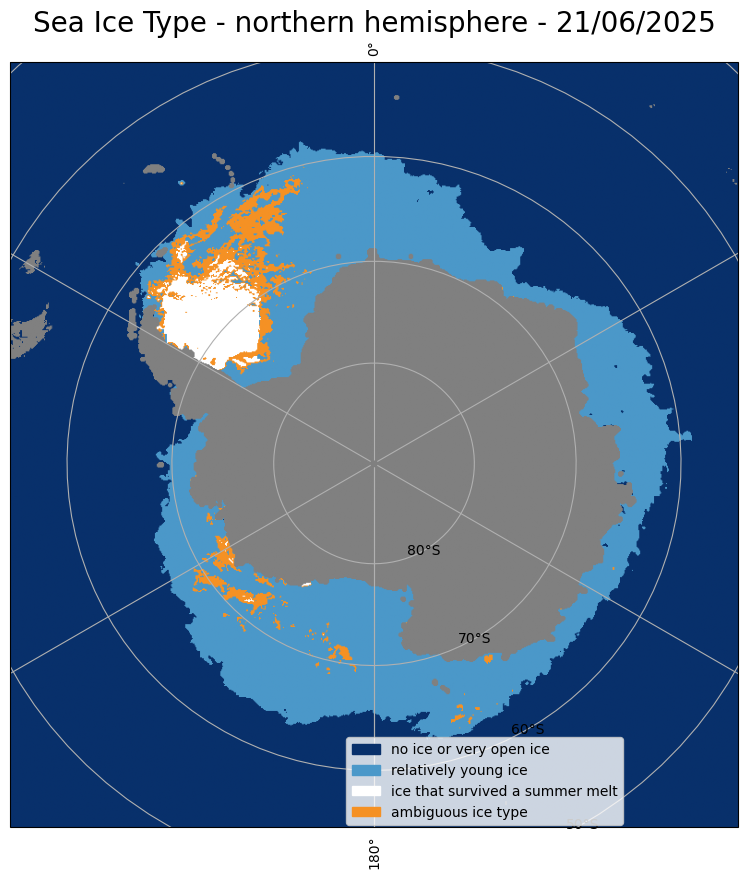

In [12]:
fig = plt.figure(figsize=(10,9))

# request output projection
hemi = 'sh'
output_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0, true_scale_latitude=-70.0)

# Map sea ice edge
im = mapping_ice_type(directory, 
                      output_projection, 
                      hemi, 
                      cmap, 
                      title="Sea Ice Type - northern hemisphere - "+ filedate)


# Add legend
add_legend(im)

<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3b_OSI_SAF_sea_ice_mapping_Ice_Edge.ipynb" target="_blank"><< Mapping OSI SAF sea ice edge</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_3d_OSI_SAF_sea_ice_mapping_Ice_Drift.ipynb" target="_blank">Mapping OSI SAF sea ice drift >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>